# Simple Statistical Methods for Heritage Analysis

## When to Use This Notebook Instead of Machine Learning

Not every analysis needs machine learning! This notebook covers **simple, transparent statistical methods** that are often more appropriate when:

- You have **fewer than 50 observations**
- You have only **2-5 variables** to analyze
- Relationships appear **straightforward and linear**
- You need to **explain results to stakeholders** who prefer traditional methods
- You want to **establish a baseline** before trying more complex approaches

### What You'll Learn

1. **Correlation Analysis**: Which variables move together?
2. **Simple Linear Regression**: How does one variable predict another?
3. **Multiple Regression**: How do several variables together predict an outcome?
4. **Group Comparisons**: Do different building types have different deterioration rates?

These methods are the foundation of data analysis. They're transparent, well-understood, and often sufficient for heritage preservation decisions.

## Step 0: Upload Your Data (Google Colab Users)

If you're running this in **Google Colab**, you need to upload your data file.

**Option 1: Manual Upload**
1. Click the folder icon 📁 on the left sidebar
2. Click the upload button and select your CSV file

**Option 2: Use the code below**

In [1]:
# Uncomment the lines below if you want to upload via code
# from google.colab import files
# uploaded = files.upload()
# print("File uploaded successfully!")

## Step 1: Load and Explore Your Data

Let's start by loading the data and taking a quick look at it.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load the data
# Replace 'heritage_data.csv' with your actual filename
try:
    df = pd.read_csv('heritage_data.csv')
    print("✓ Data loaded successfully!")
    print(f"\nDataset shape: {df.shape[0]} buildings, {df.shape[1]} variables")
    print("\nFirst few rows:")
    display(df.head())
except FileNotFoundError:
    print("❌ Error: File not found. Please upload your data file first.")
    print("Expected filename: 'heritage_data.csv'")

✓ Data loaded successfully!

Dataset shape: 200 buildings, 15 variables

First few rows:


,Building_ID,District_ID,Construction_Year,Material_Type,Foundation_Type,Avg_Temp_C,Temp_Range_C,Annual_Rainfall_mm,Humidity_Percent,Freeze_Thaw_Cycles,Soil_Moisture_Index,Crack_Width_mm,Salt_Deposition_g_m2,Condition_Rating,Intervention_Urgency
0,B001,West,1897,Stone,Pile,22.615620,11.779304,1076.431798,70.989601,9,13.517939,4.840544,5.081838,3,43.570978
1,B002,Central,1938,Brick,Deep,17.694550,9.071361,929.741978,58.789251,13,NaN,4.966796,2.995625,4,42.561086
2,B003,East,1943,Brick,Shallow,9.813769,10.978399,766.576384,61.179528,5,12.713060,3.149923,6.481649,3,36.594961
3,B004,Central,1896,Concrete,Shallow,14.048307,6.246659,829.342737,30.026990,11,11.115060,3.221341,3.973573,3,37.687773
4,B005,Central,1923,Brick,Pile,10.621909,12.772081,1041.301793,73.744915,6,18.451470,5.083610,4.542800,4,44.238911


## Step 2: Correlation Analysis

### What is Correlation?

Correlation tells you **how strongly two variables move together**:
- **+1.0**: Perfect positive relationship (when one goes up, the other always goes up)
- **0.0**: No relationship (variables are independent)
- **-1.0**: Perfect negative relationship (when one goes up, the other always goes down)

### Rules of Thumb:
- **0.0 - 0.3**: Weak correlation
- **0.3 - 0.7**: Moderate correlation
- **0.7 - 1.0**: Strong correlation

### ⚠️ Important Warning:
**Correlation does NOT mean causation!** Just because two things move together doesn't mean one causes the other. They might both be caused by a third factor, or it could be coincidence.

Analyzing correlations for 9 numerical variables:
['Construction_Year', 'Avg_Temp_C', 'Temp_Range_C', 'Annual_Rainfall_mm', 'Freeze_Thaw_Cycles', 'Soil_Moisture_Index', 'Salt_Deposition_g_m2', 'Condition_Rating', 'Intervention_Urgency']


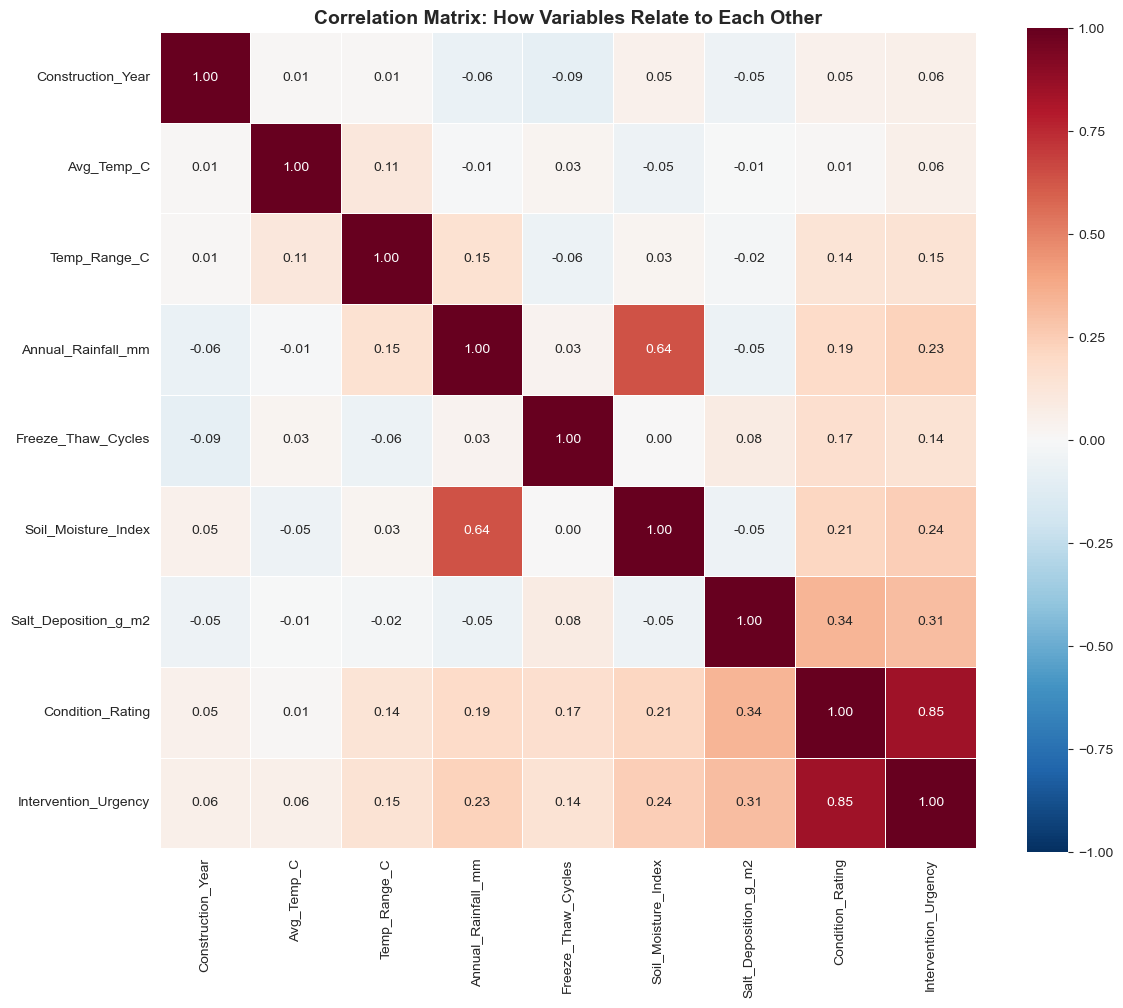


✓ Correlation matrix saved as 'correlation_matrix.png'


In [3]:
# Select only numerical columns for correlation
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove ID columns if present
numerical_cols = [col for col in numerical_cols if 'ID' not in col.upper()]

print(f"Analyzing correlations for {len(numerical_cols)} numerical variables:")
print(numerical_cols)

# Calculate correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Visualize as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            fmt='.2f',   # 2 decimal places
            cmap='RdBu_r',  # Red-Blue color scheme (red=positive, blue=negative)
            center=0,    # Center colormap at zero
            vmin=-1, vmax=1,  # Scale from -1 to +1
            square=True,
            linewidths=0.5)
plt.title('Correlation Matrix: How Variables Relate to Each Other', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Correlation matrix saved as 'correlation_matrix.png'")

### Interpreting the Correlation Matrix

**How to read the heatmap:**
- **Diagonal** (top-left to bottom-right): Always 1.0 because each variable correlates perfectly with itself
- **Red cells**: Positive correlation (variables increase together)
- **Blue cells**: Negative correlation (one increases as the other decreases)
- **White cells**: Little to no correlation

**What to look for:**
1. **Strong correlations with your outcome variable** (e.g., Condition_Rating, Crack_Width)
2. **Groups of variables that correlate with each other** (these might represent underlying factors)
3. **Unexpected correlations** that might reveal new insights

Let's find the strongest correlations:

In [4]:
# Find strongest correlations (excluding self-correlations)
# Convert correlation matrix to long format
corr_pairs = correlation_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs < 1.0]  # Remove self-correlations
corr_pairs = corr_pairs.sort_values(ascending=False)

print("=" * 70)
print("TOP 10 STRONGEST POSITIVE CORRELATIONS")
print("=" * 70)
for i, (pair, corr) in enumerate(corr_pairs.head(10).items(), 1):
    print(f"{i:2d}. {pair[0]:25s} ↔ {pair[1]:25s} : {corr:+.3f}")

print("\n" + "=" * 70)
print("TOP 10 STRONGEST NEGATIVE CORRELATIONS")
print("=" * 70)
for i, (pair, corr) in enumerate(corr_pairs.tail(10).items(), 1):
    print(f"{i:2d}. {pair[0]:25s} ↔ {pair[1]:25s} : {corr:+.3f}")

TOP 10 STRONGEST POSITIVE CORRELATIONS
 1. Intervention_Urgency      ↔ Condition_Rating          : +0.850
 2. Condition_Rating          ↔ Intervention_Urgency      : +0.850
 3. Soil_Moisture_Index       ↔ Annual_Rainfall_mm        : +0.640
 4. Annual_Rainfall_mm        ↔ Soil_Moisture_Index       : +0.640
 5. Salt_Deposition_g_m2      ↔ Condition_Rating          : +0.340
 6. Condition_Rating          ↔ Salt_Deposition_g_m2      : +0.340
 7. Intervention_Urgency      ↔ Salt_Deposition_g_m2      : +0.308
 8. Salt_Deposition_g_m2      ↔ Intervention_Urgency      : +0.308
 9. Soil_Moisture_Index       ↔ Intervention_Urgency      : +0.243
10. Intervention_Urgency      ↔ Soil_Moisture_Index       : +0.243

TOP 10 STRONGEST NEGATIVE CORRELATIONS
 1. Soil_Moisture_Index       ↔ Avg_Temp_C                : -0.053
 2. Avg_Temp_C                ↔ Soil_Moisture_Index       : -0.053
 3. Annual_Rainfall_mm        ↔ Salt_Deposition_g_m2      : -0.055
 4. Salt_Deposition_g_m2      ↔ Annual_Rainfall_mm

## Step 3: Simple Linear Regression

### What is Linear Regression?

Linear regression answers the question: **"If I know Variable X, can I predict Variable Y?"**

Think of it as drawing the "best fit" line through a scatter plot of points.

### Example Questions:
- "Does annual rainfall predict crack width?"
- "Does building age predict condition rating?"
- "Does humidity predict salt deposition?"

### Key Metrics:
- **R² (R-squared)**: How much of the variation in Y is explained by X? (0 = none, 1 = perfect)
- **p-value**: Is this relationship statistically significant? (p < 0.05 means "yes, probably real")
- **Slope**: How much does Y change when X increases by 1 unit?

Let's try an example:

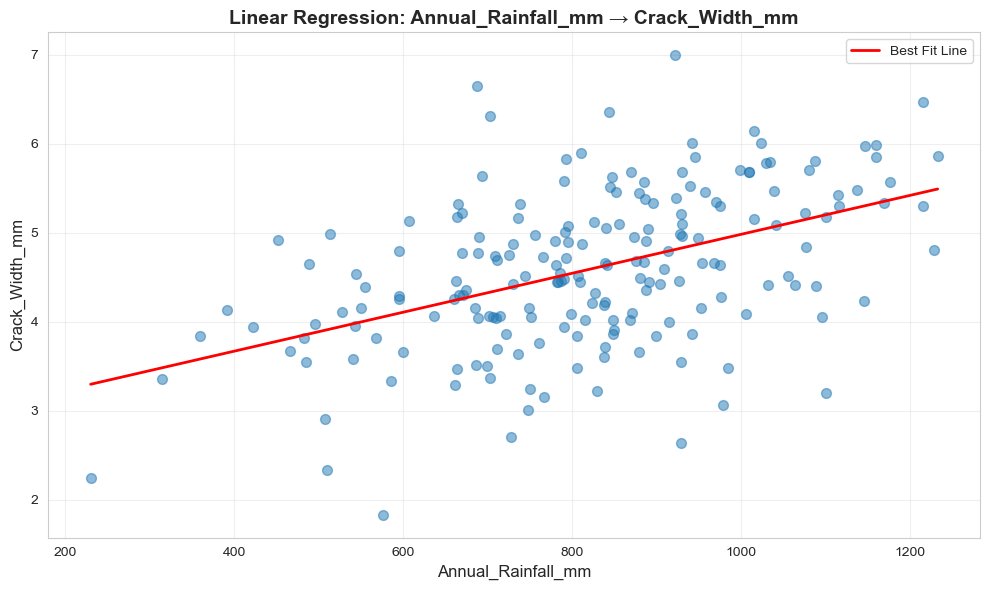

REGRESSION RESULTS
Equation: Crack_Width_mm = 0.0022 × Annual_Rainfall_mm + 2.7916

R² = 0.224  →  Annual_Rainfall_mm explains 22.4% of variation in Crack_Width_mm
p-value = 0.0000  →  ✓ Statistically significant (relationship is likely real)

Slope = 0.0022  →  Each 1-unit increase in Annual_Rainfall_mm predicts a 0.0022-unit change in Crack_Width_mm

✓ Plot saved as 'simple_regression.png'


In [5]:
# Example: Predicting Crack Width from Annual Rainfall
# Change these variable names to match your data!

predictor = 'Annual_Rainfall_mm'  # X variable (what you know)
outcome = 'Crack_Width_mm'        # Y variable (what you want to predict)

# Check if these columns exist
if predictor in df.columns and outcome in df.columns:
    # Remove any rows with missing data
    data_clean = df[[predictor, outcome]].dropna()
    
    X = data_clean[predictor]
    Y = data_clean[outcome]
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
    
    # Create scatter plot with regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(X, Y, alpha=0.5, s=50)
    
    # Plot the regression line
    x_line = np.linspace(X.min(), X.max(), 100)
    y_line = slope * x_line + intercept
    plt.plot(x_line, y_line, 'r-', linewidth=2, label=f'Best Fit Line')
    
    plt.xlabel(predictor, fontsize=12)
    plt.ylabel(outcome, fontsize=12)
    plt.title(f'Linear Regression: {predictor} → {outcome}', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('simple_regression.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print results
    print("=" * 70)
    print("REGRESSION RESULTS")
    print("=" * 70)
    print(f"Equation: {outcome} = {slope:.4f} × {predictor} + {intercept:.4f}")
    print(f"\nR² = {r_value**2:.3f}  →  {predictor} explains {r_value**2*100:.1f}% of variation in {outcome}")
    print(f"p-value = {p_value:.4f}  →  ", end="")
    if p_value < 0.05:
        print("✓ Statistically significant (relationship is likely real)")
    else:
        print("✗ Not statistically significant (might be random chance)")
    print(f"\nSlope = {slope:.4f}  →  Each 1-unit increase in {predictor} predicts a {slope:.4f}-unit change in {outcome}")
    print("\n✓ Plot saved as 'simple_regression.png'")
    
else:
    print(f"❌ Error: Columns '{predictor}' or '{outcome}' not found in your data.")
    print(f"Available columns: {df.columns.tolist()}")
    print("\nPlease change the variable names in the code above to match your data.")

### 📝 Your Turn: Try Different Variables

Go back to the cell above and change `predictor` and `outcome` to explore different relationships in your data!

**Suggestions:**
- Try predicting `Condition_Rating` from different environmental variables
- Try predicting `Intervention_Urgency` from structural variables
- Look for the strongest predictors you found in the correlation analysis

## Step 4: Multiple Regression

### What is Multiple Regression?

Simple regression uses **one** predictor. Multiple regression uses **several** predictors at once.

**Question it answers:** "If I know Variables X1, X2, and X3, can I predict Variable Y?"

**Example:** "Can I predict crack width using rainfall, temperature, and building age together?"

### Why use multiple predictors?
- Real-world deterioration depends on **multiple factors** working together
- You can see which variables matter **most** when controlling for others
- Better predictions than using just one variable

Let's build a multiple regression model:

### Understanding the Tools: What is sklearn?

Before we dive into the code, let's understand the tools we're using:

#### **What is sklearn (scikit-learn)?**

Think of **sklearn** as a toolbox full of pre-built statistical and machine learning tools. Instead of building a hammer from scratch, you grab one from the toolbox.

**Analogy**: 
- **Without sklearn**: "I need to calculate a regression... let me write 200 lines of math code"
- **With sklearn**: "I need a regression... let me grab the ready-made regression tool"

#### **Key Concepts You'll See:**

**1. Importing (getting tools from the toolbox)**
```python
from sklearn.linear_model import LinearRegression
```
Translation: "Get me the LinearRegression tool from the toolbox"

**2. Creating a model (taking the tool out)**
```python
model = LinearRegression()
```
Translation: "Create a new regression tool and call it 'model'"

**3. Fitting (teaching the model)**
```python
model.fit(X, y)
```
Translation: "Learn the relationship between X (predictors) and y (outcome)"

**Analogy**: Like showing a student (model) many examples (X, y) so they learn the pattern.

**4. Predicting (using what it learned)**
```python
predictions = model.predict(X)
```
Translation: "Now that you've learned, make predictions for these new cases"

#### **The Standard Workflow:**

Every sklearn model follows the same pattern:
1. **Import** the tool you need
2. **Create** an instance of the model
3. **Fit** the model to your data (teach it)
4. **Predict** or analyze results (use it)

**You don't need to understand the math inside** — sklearn handles that. You just need to:
- Prepare your data correctly
- Tell the model what to learn
- Interpret the results

Let's see this in action:

Using 184 buildings with complete data

MULTIPLE REGRESSION RESULTS

Predicting: Condition_Rating
Using: Avg_Temp_C, Annual_Rainfall_mm, Humidity_Percent, Crack_Width_mm, Salt_Deposition_g_m2

R² = 0.195  →  Model explains 19.5% of variation in Condition_Rating
MAE = 1.114  →  Average prediction error is 1.114 units

VARIABLE IMPORTANCE (Coefficients)

How much each variable contributes to the prediction:
(Larger absolute values = stronger influence)

Crack_Width_mm                 : +0.3211  (↑ increases Condition_Rating)
Salt_Deposition_g_m2           : +0.2427  (↑ increases Condition_Rating)
Humidity_Percent               : +0.0017  (↑ increases Condition_Rating)
Annual_Rainfall_mm             : +0.0009  (↑ increases Condition_Rating)
Avg_Temp_C                     : -0.0007  (↓ decreases Condition_Rating)

Intercept: -0.5648


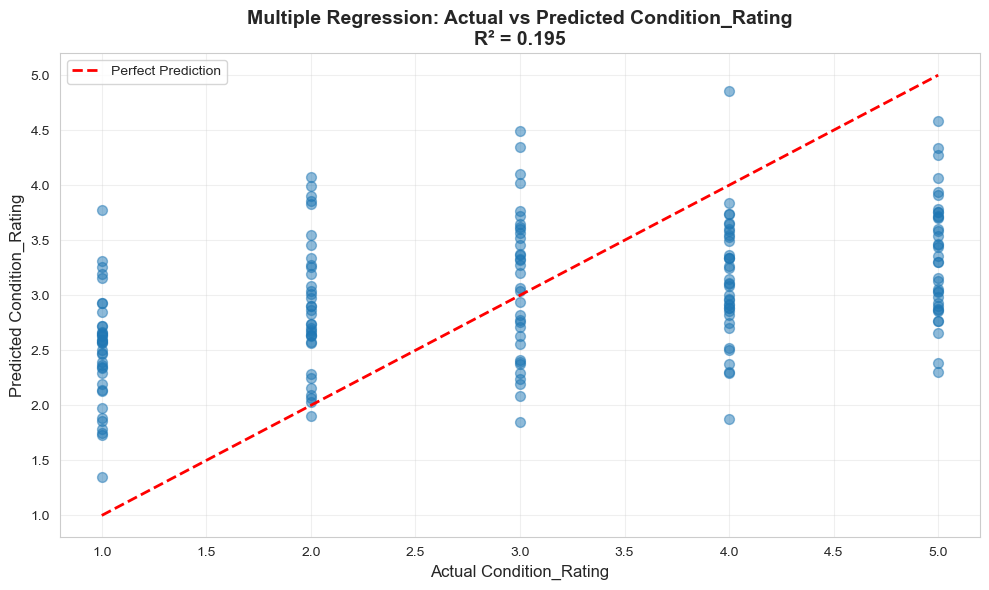


✓ Plot saved as 'multiple_regression.png'


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Define your outcome variable
outcome_var = 'Condition_Rating'  # Change this to your target variable

# Define your predictor variables
predictor_vars = [
    'Avg_Temp_C',
    'Annual_Rainfall_mm',
    'Humidity_Percent',
    'Crack_Width_mm',
    'Salt_Deposition_g_m2'
]  # Change these to match your data

# Check if columns exist
missing_cols = [col for col in predictor_vars + [outcome_var] if col not in df.columns]
if missing_cols:
    print(f"❌ Error: These columns are not in your data: {missing_cols}")
    print(f"\nAvailable columns: {df.columns.tolist()}")
else:
    # Prepare data (remove missing values)
    data_clean = df[predictor_vars + [outcome_var]].dropna()
    
    X = data_clean[predictor_vars]
    y = data_clean[outcome_var]
    
    print(f"Using {len(data_clean)} buildings with complete data\n")
    
    # Fit the model
    model = LinearRegression()
    model.fit(X, y)
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Calculate performance metrics
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    
    # Print results
    print("=" * 70)
    print("MULTIPLE REGRESSION RESULTS")
    print("=" * 70)
    print(f"\nPredicting: {outcome_var}")
    print(f"Using: {', '.join(predictor_vars)}")
    print(f"\nR² = {r2:.3f}  →  Model explains {r2*100:.1f}% of variation in {outcome_var}")
    print(f"MAE = {mae:.3f}  →  Average prediction error is {mae:.3f} units")
    
    print("\n" + "=" * 70)
    print("VARIABLE IMPORTANCE (Coefficients)")
    print("=" * 70)
    print("\nHow much each variable contributes to the prediction:")
    print("(Larger absolute values = stronger influence)\n")
    
    # Create a dataframe of coefficients
    coef_df = pd.DataFrame({
        'Variable': predictor_vars,
        'Coefficient': model.coef_,
        'Abs_Coefficient': np.abs(model.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    for idx, row in coef_df.iterrows():
        direction = "↑ increases" if row['Coefficient'] > 0 else "↓ decreases"
        print(f"{row['Variable']:30s} : {row['Coefficient']:+.4f}  ({direction} {outcome_var})")
    
    print(f"\nIntercept: {model.intercept_:.4f}")
    
    # Visualize: Actual vs Predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.5, s=50)
    
    # Plot perfect prediction line
    min_val = min(y.min(), y_pred.min())
    max_val = max(y.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    plt.xlabel(f'Actual {outcome_var}', fontsize=12)
    plt.ylabel(f'Predicted {outcome_var}', fontsize=12)
    plt.title(f'Multiple Regression: Actual vs Predicted {outcome_var}\nR² = {r2:.3f}', 
              fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('multiple_regression.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Plot saved as 'multiple_regression.png'")

### Checking for Multicollinearity with VIF

#### What is Multicollinearity?

**Multicollinearity** occurs when predictor variables are highly correlated with each other. This is a problem because:

- **Unstable coefficients**: Small changes in data cause large changes in coefficients
- **Misleading importance**: Can't tell which variable truly matters
- **Inflated standard errors**: Statistical tests become unreliable

**Example**: If you include both "Annual Rainfall" and "Humidity" as predictors, they're likely highly correlated (rainy places are humid). The model can't separate their individual effects.

#### What is VIF (Variance Inflation Factor)?

VIF measures how much a variable's variance is "inflated" due to correlation with other variables.

**How it works**:
1. For each predictor variable, VIF asks: "How well can the OTHER variables predict THIS variable?"
2. If other variables predict it well → high correlation → high VIF
3. If other variables can't predict it → independent → low VIF

**Interpretation**:
- **VIF = 1**: No correlation with other variables (perfect!)
- **VIF = 1-5**: Moderate correlation (usually acceptable)
- **VIF = 5-10**: High correlation (concerning, investigate)
- **VIF > 10**: Severe multicollinearity (problematic, take action)

#### Why Check VIF?

In heritage data, multicollinearity is common:
- Environmental variables correlate (temperature ↔ humidity ↔ rainfall)
- Deterioration indicators correlate (crack width ↔ salt deposition ↔ moisture)
- Temporal variables correlate (building age ↔ construction era)

**Before trusting regression coefficients, check VIF!**

Let's calculate VIF for our multiple regression model:

MULTICOLLINEARITY CHECK: Variance Inflation Factor (VIF)

VIF measures how much each variable correlates with others.
Higher VIF = more correlation = potential multicollinearity problem

            Variable       VIF               Assessment
      Crack_Width_mm 43.362774     ✗ High (problematic)
  Annual_Rainfall_mm 22.711768     ✗ High (problematic)
    Humidity_Percent 18.288831     ✗ High (problematic)
          Avg_Temp_C  8.433407 ⚠ Moderate (investigate)
Salt_Deposition_g_m2  6.435328 ⚠ Moderate (investigate)

ASSESSMENT
✗ Severe multicollinearity detected! 3 variable(s) with VIF > 10:
  - Crack_Width_mm: VIF = 43.36
  - Annual_Rainfall_mm: VIF = 22.71
  - Humidity_Percent: VIF = 18.29

  → Regression coefficients are unreliable!
  → ACTION REQUIRED (see solutions below)


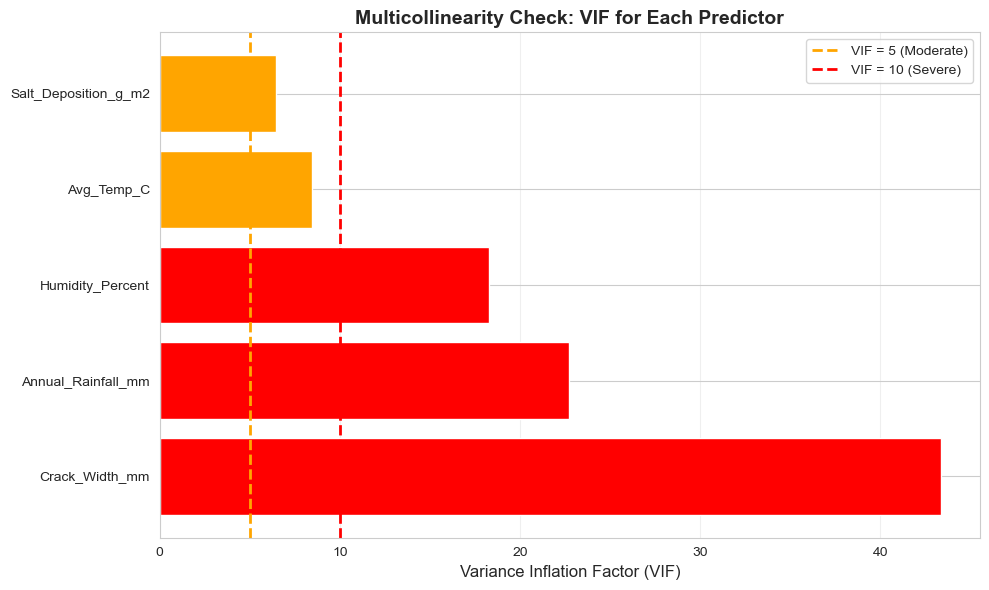


✓ VIF plot saved as 'vif_multicollinearity.png'


In [7]:
# Calculate VIF (Variance Inflation Factor) for multicollinearity detection
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Check if we have the data from the multiple regression above
if 'X' in locals() and 'predictor_vars' in locals():
    print("="*70)
    print("MULTICOLLINEARITY CHECK: Variance Inflation Factor (VIF)")
    print("="*70)
    print("\nVIF measures how much each variable correlates with others.")
    print("Higher VIF = more correlation = potential multicollinearity problem\n")
    
    # Calculate VIF for each predictor
    vif_data = pd.DataFrame()
    vif_data["Variable"] = predictor_vars
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(predictor_vars))]
    
    # Sort by VIF (highest first)
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    # Add interpretation
    def interpret_vif(vif):
        if vif < 5:
            return "✓ Low (acceptable)"
        elif vif < 10:
            return "⚠ Moderate (investigate)"
        else:
            return "✗ High (problematic)"
    
    vif_data["Assessment"] = vif_data["VIF"].apply(interpret_vif)
    
    print(vif_data.to_string(index=False))
    
    # Overall assessment
    max_vif = vif_data["VIF"].max()
    problem_vars = vif_data[vif_data["VIF"] > 10]
    
    print("\n" + "="*70)
    print("ASSESSMENT")
    print("="*70)
    
    if max_vif < 5:
        print("✓ No multicollinearity detected. All VIF values < 5.")
        print("  → Regression coefficients are reliable.")
    elif max_vif < 10:
        print("⚠ Moderate multicollinearity detected (VIF 5-10).")
        print("  → Coefficients may be somewhat unstable.")
        print("  → Consider: Remove one variable from correlated pairs.")
    else:
        print(f"✗ Severe multicollinearity detected! {len(problem_vars)} variable(s) with VIF > 10:")
        for _, row in problem_vars.iterrows():
            print(f"  - {row['Variable']}: VIF = {row['VIF']:.2f}")
        print("\n  → Regression coefficients are unreliable!")
        print("  → ACTION REQUIRED (see solutions below)")
    
    # Visualize VIF
    plt.figure(figsize=(10, 6))
    colors = ['red' if vif > 10 else 'orange' if vif > 5 else 'green' 
              for vif in vif_data['VIF']]
    plt.barh(vif_data['Variable'], vif_data['VIF'], color=colors)
    plt.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='VIF = 5 (Moderate)')
    plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='VIF = 10 (Severe)')
    plt.xlabel('Variance Inflation Factor (VIF)', fontsize=12)
    plt.title('Multicollinearity Check: VIF for Each Predictor', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('vif_multicollinearity.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ VIF plot saved as 'vif_multicollinearity.png'")
    
else:
    print("❌ Please run the multiple regression code above first.")

### What to Do About High VIF (> 10)

If you found severe multicollinearity (VIF > 10), here are your options:

#### **Option 1: Remove Redundant Variables** (Simplest)

If two variables are highly correlated, remove one:

**Example**: If "Annual_Rainfall" and "Humidity" both have VIF > 10:
- Check their correlation: `df[['Annual_Rainfall', 'Humidity']].corr()`
- If correlation > 0.8, they measure similar things
- Keep the one more directly related to your outcome
- Remove the other from `predictor_vars`

```python
# Remove one correlated variable
predictor_vars = ['Avg_Temp_C', 'Annual_Rainfall_mm', 'Crack_Width_mm']  # Removed Humidity
# Re-run regression and VIF
```

#### **Option 2: Combine Correlated Variables** (Create Index)

If multiple variables measure the same concept, combine them:

**Example**: Create a "Moisture Index" from rainfall, humidity, and soil moisture:
```python
# Standardize first (so they're on same scale)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
moisture_vars = df[['Annual_Rainfall_mm', 'Humidity_Percent', 'Soil_Moisture_Index']]
moisture_scaled = scaler.fit_transform(moisture_vars)

# Create composite index (average)
df['Moisture_Index'] = moisture_scaled.mean(axis=1)

# Use Moisture_Index instead of individual variables
predictor_vars = ['Avg_Temp_C', 'Moisture_Index', 'Crack_Width_mm']
```

#### **Option 3: Use Ridge Regression** (Handles Multicollinearity)

Ridge regression is designed to handle correlated predictors:

```python
from sklearn.linear_model import Ridge

# Ridge regression with regularization
ridge_model = Ridge(alpha=1.0)  # alpha controls regularization strength
ridge_model.fit(X, y)
y_pred_ridge = ridge_model.predict(X)

# Ridge coefficients are more stable with multicollinearity
print("Ridge coefficients:", ridge_model.coef_)
```

#### **Option 4: Use Factor Analysis** (Advanced)

If you have many correlated variables, use **Notebook 02: Factor Analysis** to:
- Group correlated variables into factors
- Use factor scores as predictors (factors are uncorrelated by design)
- Eliminates multicollinearity automatically

#### **Option 5: Use Tree-Based Models** (Alternative)

Random Forest and Gradient Boosting (Notebook 03) are **not affected by multicollinearity**:
- They handle correlated predictors naturally
- Feature importance rankings remain valid
- No need to remove variables

**Trade-off**: Less interpretable than regression coefficients

---

### Decision Guide

| Situation | Recommended Solution |
|-----------|---------------------|
| 2-3 variables with VIF > 10 | Remove one from each correlated pair |
| Many correlated environmental variables | Combine into indices or use Factor Analysis |
| Need linear regression coefficients | Use Ridge Regression |
| Don't need interpretable coefficients | Use Random Forest (Notebook 03) |
| Exploratory analysis | Try multiple approaches, compare |

---

### Key Takeaway

**Always check VIF before trusting regression coefficients!**

- VIF < 5: ✓ Coefficients are reliable
- VIF 5-10: ⚠ Coefficients may be unstable
- VIF > 10: ✗ Coefficients are unreliable, take action

**Heritage data often has multicollinearity** (environmental variables correlate). This is normal! Just be aware and handle it appropriately.

### Interpreting Multiple Regression Results

**R² (R-squared):**
- **0.0 - 0.3**: Weak model (not very useful)
- **0.3 - 0.7**: Moderate model (useful for prioritization)
- **0.7 - 1.0**: Strong model (good predictions)

**Coefficients:**
- **Positive coefficient**: Variable increases → Outcome increases
- **Negative coefficient**: Variable increases → Outcome decreases
- **Larger absolute value**: Stronger influence

**MAE (Mean Absolute Error):**
- Average prediction error in the same units as your outcome
- Lower is better
- Example: MAE = 0.5 on a 1-5 condition scale means predictions are typically off by half a rating point

### ⚠️ Important Limitations

1. **Linear relationships only**: Regression assumes straight-line relationships. If your data has curves or thresholds, it won't work well.
2. **Correlation ≠ Causation**: High coefficients show association, not proof of cause-and-effect.
3. **Multicollinearity**: If predictor variables are highly correlated with each other, coefficients become unreliable.
4. **Outliers**: A few extreme values can distort the entire model.

## Step 5: Comparing Groups

### When to Use Group Comparisons

Sometimes you want to know: **"Do different groups have different average values?"**

**Examples:**
- Do brick buildings deteriorate faster than stone buildings?
- Do buildings in the North district have higher crack widths than those in the South?
- Do buildings from different construction periods have different condition ratings?

We'll use **box plots** to visualize differences and **statistical tests** to check if differences are real or just random variation.

/var/folders/t0/r5nh9gq553jgwbsh46rsbhr00000gn/T/ipykernel_70918/2678463180.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_clean, x=group_variable, y=outcome_variable, palette='Set2')


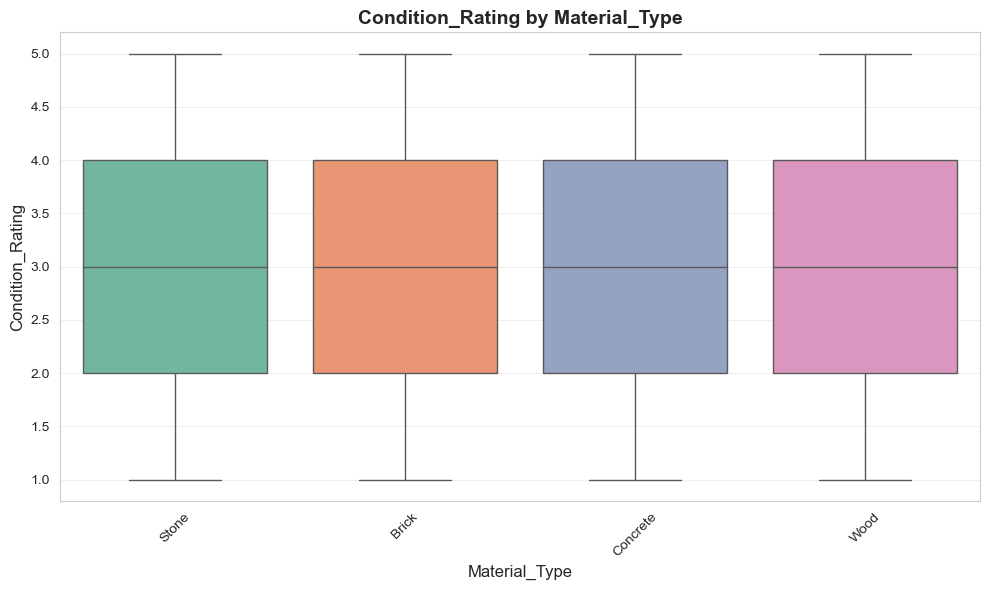

SUMMARY STATISTICS: Condition_Rating by Material_Type
               Count  Mean  Std Dev  Min  Max
Material_Type                                
Brick             77  2.99     1.42    1    5
Concrete          39  3.08     1.51    1    5
Stone             56  2.89     1.42    1    5
Wood              28  3.14     1.33    1    5

STATISTICAL TEST (ANOVA)
F-statistic = 0.239
p-value = 0.8691

✗ Groups are NOT significantly different (p ≥ 0.05)
   → Differences might be due to random chance

✓ Plot saved as 'group_comparison.png'


In [8]:
# Example: Compare Condition Rating across Material Types
group_variable = 'Material_Type'  # Categorical variable (groups)
outcome_variable = 'Condition_Rating'  # Numerical variable to compare

# Check if columns exist
if group_variable in df.columns and outcome_variable in df.columns:
    # Remove missing values
    data_clean = df[[group_variable, outcome_variable]].dropna()
    
    # Create box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data_clean, x=group_variable, y=outcome_variable, palette='Set2')
    plt.xlabel(group_variable, fontsize=12)
    plt.ylabel(outcome_variable, fontsize=12)
    plt.title(f'{outcome_variable} by {group_variable}', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('group_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate summary statistics for each group
    print("=" * 70)
    print(f"SUMMARY STATISTICS: {outcome_variable} by {group_variable}")
    print("=" * 70)
    summary = data_clean.groupby(group_variable)[outcome_variable].agg([
        ('Count', 'count'),
        ('Mean', 'mean'),
        ('Std Dev', 'std'),
        ('Min', 'min'),
        ('Max', 'max')
    ]).round(2)
    print(summary)
    
    # Perform statistical test (ANOVA)
    groups = [group[outcome_variable].values for name, group in data_clean.groupby(group_variable)]
    f_stat, p_value = stats.f_oneway(*groups)
    
    print("\n" + "=" * 70)
    print("STATISTICAL TEST (ANOVA)")
    print("=" * 70)
    print(f"F-statistic = {f_stat:.3f}")
    print(f"p-value = {p_value:.4f}")
    
    if p_value < 0.05:
        print("\n✓ Groups are SIGNIFICANTLY DIFFERENT (p < 0.05)")
        print(f"   → {group_variable} appears to influence {outcome_variable}")
    else:
        print("\n✗ Groups are NOT significantly different (p ≥ 0.05)")
        print(f"   → Differences might be due to random chance")
    
    print("\n✓ Plot saved as 'group_comparison.png'")
    
else:
    print(f"❌ Error: Columns '{group_variable}' or '{outcome_variable}' not found.")
    print(f"Available columns: {df.columns.tolist()}")

### Understanding Box Plots

Each box shows the distribution of values for one group:

- **Box**: Contains the middle 50% of values
- **Line inside box**: Median (middle value)
- **Whiskers**: Extend to show the range of typical values
- **Dots beyond whiskers**: Outliers (unusual values)

**What to look for:**
- **Different median lines**: Groups have different typical values
- **Non-overlapping boxes**: Strong evidence of real differences
- **Wide boxes**: High variability within that group

### Understanding p-values

- **p < 0.05**: "Statistically significant" - differences are probably real, not random
- **p ≥ 0.05**: "Not significant" - differences might just be random variation

**Important:** Statistical significance doesn't always mean practical importance! A tiny difference can be "significant" with lots of data, but not matter for real decisions.

## Summary: When to Use Each Method

| Method | When to Use | Example Question |
|--------|-------------|------------------|
| **Correlation** | Explore relationships between variables | Which variables move together? |
| **Simple Regression** | Predict outcome from ONE variable | Does rainfall predict crack width? |
| **Multiple Regression** | Predict outcome from SEVERAL variables | Can I predict condition using rainfall, temperature, and age? |
| **Group Comparison** | Compare averages across categories | Do brick buildings deteriorate faster than stone? |

### When to Move to Machine Learning

Consider the advanced methods (Factor Analysis, Random Forest) from the other notebooks when:

1. **You have many variables** (10+) and need to reduce complexity
2. **Relationships are non-linear** (curves, thresholds, interactions)
3. **You have lots of data** (100+ observations)
4. **Simple regression R² is low** (< 0.3) but you think patterns exist
5. **Variables interact** in complex ways (e.g., humidity + temperature together matter more than either alone)

### Advantages of Simple Methods

✓ **Easy to explain** to stakeholders and review boards  
✓ **Transparent** - you can see exactly what's happening  
✓ **Fast** - results in seconds  
✓ **Robust** with small datasets  
✓ **Well-understood** - decades of established practice  

**Bottom line:** Start simple. Only add complexity when simple methods don't work.

## Next Steps

### If simple methods worked well:
- Use your regression equations to make predictions
- Focus monitoring on the variables with strongest correlations
- Share your clear, transparent results with stakeholders

### If simple methods gave weak results (R² < 0.3):
- Try **Notebook 2: Factor Analysis** to reduce complexity
- Try **Notebook 3: Feature Importance** to capture non-linear relationships
- Consider collecting more data or different variables

### Save Your Results

All plots have been saved as PNG files:
- `correlation_matrix.png`
- `simple_regression.png`
- `multiple_regression.png`
- `group_comparison.png`

You can download these and include them in reports!

## Troubleshooting

### "Column not found" errors
- Check your column names match exactly (case-sensitive!)
- Use `df.columns.tolist()` to see all available columns
- Update variable names in the code to match your data

### Low R² values
- Normal for complex heritage data! R² = 0.3-0.5 can still be useful
- Try different predictor variables
- Consider non-linear methods (Notebooks 2-3)

### "Not statistically significant" results
- You might need more data
- The relationship might be weak or non-existent
- Try different variables or groupings

### Outliers affecting results
- Check if outliers are data errors (fix them!)
- If outliers are real (e.g., storm damage), consider analyzing separately
- Try robust regression methods (beyond this notebook's scope)

### Questions?
- Review the markdown explanations above each code cell
- Try changing one variable at a time to understand what each does
- Consult a statistician for complex cases or high-stakes decisions